In [27]:
from hexalattice.hexalattice import create_hex_grid
import numpy as np
import meshio
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import os
from collections import deque
from numba import jit

output_folder = "simulation_results"
os.makedirs(output_folder, exist_ok=True)

# Parameters for the hexagonal grid
nx, ny = 25, 40  # Number of hexagons in the x and y directions
dx = 1           # Distance between centers of hexagons

# Create hexagonal grid
hex_centers, hex_grid = create_hex_grid(nx=nx, ny=ny, do_plot=False, min_diam=dx)

def get_hex_vertices(center):
    # Get vertices of hexagon with given center
    radius = 2/np.sqrt(3)*dx/2
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 vertices
    vertices = np.column_stack((center[0] + radius * np.cos(angles + np.pi/2),
                                center[1] + radius * np.sin(angles + np.pi/2)))
    return vertices

# Collect all vertices in the grid
hex_vertices_list = []
for center in hex_centers:
    hex_vertices_list.append(get_hex_vertices(center))
hex_vertices_array = np.vstack(hex_vertices_list)

# Ensure unique vertices and reshape cells
unique_vertices, indices = np.unique(hex_vertices_array.round(decimals=6), axis=0, return_inverse=True)
hex_cells = np.reshape(indices, (-1, 6))

# Define unique edges
unique_edges = []
for hexagon in hex_cells:
    for i in range(len(hexagon)):
        node1 = hexagon[i]
        node2 = hexagon[(i + 1) % len(hexagon)]  
        edge = tuple(sorted((node1, node2)))  
        if edge not in unique_edges:
            unique_edges.append(edge)

# Identify boundary nodes and edges
point_ids = np.arange(len(unique_vertices))
boundary_id = np.zeros(len(unique_vertices))

boundary_l, boundary_r, boundary_t, boundary_b = [], [], [], []
for i in point_ids:
    idx = np.where(hex_cells == i)
    if (1 in idx[1] and 5 not in idx[1]) or (2 in idx[1] and 4 not in idx[1]):
        boundary_l.append(i)
    if (5 in idx[1] and 1 not in idx[1]) or (4 in idx[1] and 2 not in idx[1]):
        boundary_r.append(i)
    if (0 in idx[1] and 2 not in idx[1] and 4 not in idx[1]) or (1 in idx[1] and 3 not in idx[1] and 5 in idx[1]):
        boundary_t.append(i)
    if (3 in idx[1] and 1 not in idx[1] and 5 not in idx[1]) or (4 in idx[1] and 0 not in idx[1] and 2 in idx[1]):
        boundary_b.append(i)

boundary_id[np.unique(boundary_t)] = 1
boundary_id[np.unique(boundary_b)] = 2
boundary_id[np.unique(boundary_l)] = 3
boundary_id[np.unique(boundary_r)] = 4

# Identify edges on/connected to boundary
boundary_status = np.zeros(len(unique_edges))
for e in range(len(unique_edges)):
    node1, node2 = unique_edges[e]
    if boundary_id[node1] > 0 and boundary_id[node2] > 0:
        boundary_status[e] = 2
    elif (boundary_id[node1] > 0 and boundary_id[node2] == 0) or (boundary_id[node1] == 0 and boundary_id[node2] > 0):
        boundary_status[e] = 1

# Export to VTK
points = unique_vertices
mesh = meshio.Mesh(points, [("line", unique_edges)], point_data={'Boundary_nodes': boundary_id}, cell_data={'Boundary_edges': [boundary_status]})

output_file_edge = os.path.join(output_folder, "hexagonal_mesh_EDGE.vtk")
meshio.write(output_file_edge, mesh)


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

In [28]:
def identify_regions(spring_constants, k_fibrosis, k_normal):
    """
    Identify which springs are inside the stiffened region and which are on the edge.
    Returns two boolean arrays: inside_region, edge_region.
    """
    inside_region = np.zeros(len(spring_constants), dtype=bool)
    edge_region = np.zeros(len(spring_constants), dtype=bool)
    
    # Iterate over each spring
    for spring_index, k_value in enumerate(spring_constants):
        # Identify neighbors of the current spring
        nodes = edges[spring_index]
        connected = np.where((nodes[0] == edges[:, 0]) | 
                             (nodes[0] == edges[:, 1]) | 
                             (nodes[1] == edges[:, 0]) | 
                             (nodes[1] == edges[:, 1]))[0]
        
        neighbor_stiffness = spring_constants[connected]
        
        # If all neighbors are stiff, the spring is inside the stiffened region
        if np.all(neighbor_stiffness >= 30):
            inside_region[spring_index] = True
        # If some neighbors are stiff and some are normal, it's on the edge
        elif np.any(neighbor_stiffness >= 30) and np.any(neighbor_stiffness == 30):
            edge_region[spring_index] = True
    
    return inside_region, edge_region

def compute_strain_and_stress(points, edges, l0, spring_constants):
    """
    Compute strain and stress for each spring based on the current positions.
    Returns two arrays: strain and stress.
    """
    strain = np.zeros(len(edges))
    stress = np.zeros(len(edges))

    for i, edge in enumerate(edges):
        node1, node2 = edge
        p1, p2 = points[node1], points[node2]

        # Calculate current length of the spring
        current_length = np.linalg.norm(p2 - p1)
        
        # Calculate strain and stress
        strain[i] = (current_length - l0) / l0
        stress[i] = spring_constants[i] * strain[i]

    return strain, stress


def compute_spring_force(p1, p2, l0, k):
    current_length = np.linalg.norm(p2 - p1)
    displacement = current_length - l0
    force_magnitude = k * displacement  # Force magnitude based on spring constant

    direction = (p2 - p1) / current_length
    force = force_magnitude * direction
    return force

# Calculate forces on each node from all connected springs
@jit(nopython=True)
def compute_total_forces_numba(forces_on_nodes, points, edges, l0, spring_constants):
    forces_on_nodes[:] = 0  # Reset forces to zero at each iteration
    for i in range(len(edges)):
        node1, node2 = edges[i]
        p1, p2 = points[node1], points[node2]

        # Compute force directly without additional function call
        current_length = np.linalg.norm(p2 - p1)
        displacement = current_length - l0
        force_magnitude = spring_constants[i] * displacement
        direction = (p2 - p1) / current_length

        force = force_magnitude * direction

        forces_on_nodes[node1] += force
        forces_on_nodes[node2] -= force  # Opposite force on node2

@jit(nopython=True)
def move_nodes_numba(points, forces_on_nodes, mu, free_nodes):
    for i in free_nodes[0]:  # Iterate only over free nodes
        points[i] += mu * forces_on_nodes[i]

@jit(nopython=True)
def compute_total_energy_numba(points, edges, l0, spring_constants):
    total_energy = 0.0
    for i in range(len(edges)):
        node1, node2 = edges[i]
        p1, p2 = points[node1], points[node2]

        # Calculate energy directly
        current_length = np.linalg.norm(p2 - p1)
        displacement = current_length - l0
        energy = 0.5 * spring_constants[i] * displacement ** 2
        total_energy += energy
    return total_energy

# Remove specified edges and corresponding spring constants
def remove_edge(edges, points, spring_constants, removed_id):
    point_ids = np.arange(len(points))
    
    # Step 1: Remove edges that should be removed
    for i in removed_id:
        edges = np.delete(edges, i, axis=0)
        spring_constants = np.delete(spring_constants, i, axis=0)

    # Step 2: Remove edges that have become disconnected after Step 1
    for i in point_ids:
        idx = np.where(edges == i)
        n_of_edges = len(idx[0])

        if n_of_edges==1:
            edges = np.delete(edges, idx[0], axis=0)
            spring_constants = np.delete(spring_constants, idx[0], axis=0)

    return edges, spring_constants

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [29]:
def simulate(points, edges, l0, spring_constants, mu, T, tolerance, max_iterations, free_nodes, plot_bar=True, print_results=False, energy_plot=True):
    if plot_bar:
        progress_bar = tqdm(total=max_iterations, desc="Simulation Progress")

    iteration = 0
    previous_energy = compute_total_energy_numba(points, edges, l0, spring_constants)
    delta_energy = 10
    stagnation_counter = 0
    stagnation = False

    # Set up tracking for energy
    energy = [] if energy_plot else None
    forces_on_nodes = np.zeros_like(points)  # Initialize forces array

    while iteration < max_iterations and not stagnation:
        # In-place force calculation
        compute_total_forces_numba(forces_on_nodes, points, edges, l0, spring_constants)

        temp_points = points.copy()
        # In-place node movement
        move_nodes_numba(temp_points, forces_on_nodes, mu, free_nodes)

        # In-place energy calculation
        new_energy = compute_total_energy_numba(temp_points, edges, l0, spring_constants)

        if energy_plot:
            energy.append(new_energy)

        delta_energy = new_energy - previous_energy
        relative_energy_change = abs(delta_energy) / abs(new_energy)
        stagnation_counter = stagnation_counter + 1 if relative_energy_change < tolerance else 0
        stagnation = stagnation_counter >= 20

        # Acceptance criteria
        if delta_energy < 0:
            previous_energy = new_energy
            points = temp_points
            mu *= 1.1
            P = 0
        else:
            P = np.exp(-delta_energy / T)
            if np.random.random() < P:
                previous_energy = new_energy
                points = temp_points
            else:
                mu *= 0.9  # Reject configuration

        T *= 0.99
        iteration += 1
        if plot_bar:
            progress_bar.update(1)

        if print_results and (iteration == 1 or iteration % 250 == 0):
            print(f"Iteration {iteration}, mu: {mu}, T: {T}, P = {P}")
            print(f"New energy: {new_energy}")
            print("Energy change:", delta_energy)
            print("Number of edges:", len(edges))

    if energy_plot:
        plot_energy(energy)

    return points, edges, spring_constants
def plot_energy(energy):

    plt.plot(energy)

    plt.xlabel("Number of iterations")
    plt.ylabel("Total energy")

    plt.show()
    plt.clf()

Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

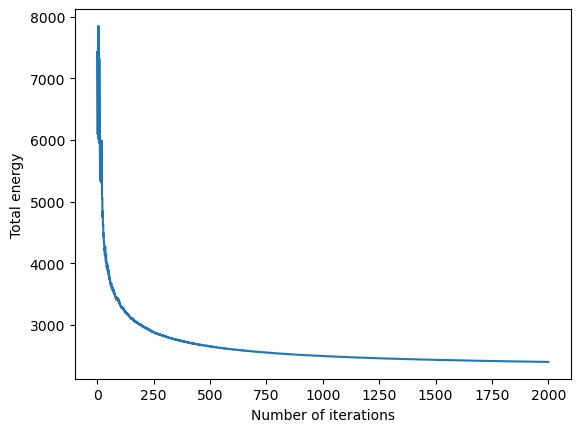

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

<Figure size 640x480 with 0 Axes>

In [30]:
# Load the mesh with edges
mesh_path = "simulation_results/hexagonal_mesh_EDGE.vtk"  # Specify the path to the mesh file
mesh_EDGE = meshio.read(mesh_path)  # Load edges from VTK file

# Extract the points (coordinates) and edges (line cells)
points = mesh_EDGE.points[:, :2]  # Use only x, y coordinates for 2D mesh
edges = mesh_EDGE.cells_dict['line']  # Get line elements representing edges

# Boundary identification
boundary_node_ids = mesh_EDGE.point_data['Boundary_nodes']
boundary_edge_ids = mesh_EDGE.cell_data['Boundary_edges'][0]

# Simulation parameters
k_normal = 1.0             # Normal spring constant for healthy springs
k_fibrosis = 100 * k_normal  # Increased stiffness for fibrotic springs
dx = 1.0                    # Initial distance factor (ensure you update this as needed)
l0 = 0.4 * (2 / np.sqrt(3) * dx / 2)  # Rest length for the springs
mu = 0.01                   # Initial step size for nodal movement
T = 1.0                     # Initial temperature for simulated annealing
max_iterations = 1200        # Maximum iterations for each convergence cycle
tolerance = 1e-7            # Tolerance for convergence based on relative energy change
spring_constants = np.full(len(edges), k_normal)  # All springs start with normal stiffness
# random walk parameters
alpha = 0.4                # Proportion of springs that will become fibrotic
walk_length = 300           # Length of the random walk for fibrosis spread


# Free nodes (not on boundary)
free_nodes = np.where(boundary_node_ids == 0)

# Run the random walk for fibrosis initialization
healthy_ids = np.where((spring_constants == k_normal))[0]
while len(healthy_ids) / len(edges) > 1 - alpha:
    #feasible_ids = np.where(spring_constants == k_normal)[0]
    feasible_ids = np.where((spring_constants==k_normal)&(boundary_edge_ids == 1 ))[0]
    new_stiff = np.random.choice(feasible_ids)
    spring_constants[new_stiff] = k_fibrosis

    # Do random walk (spread fibrosis)
    for i in range(walk_length):
        nodes = edges[new_stiff]
        connected = np.where(
            (nodes[0] == edges[:, 0]) | (nodes[0] == edges[:, 1]) | (nodes[1] == edges[:, 0]) | (nodes[1] == edges[:, 1])
        )
        new_stiff = np.random.choice(connected[0])
        spring_constants[new_stiff] = k_fibrosis

    # Update
    healthy_ids = np.where((spring_constants == k_normal))[0]

# Pre-converge step
points = np.asarray(points, dtype=np.float64)
edges = np.asarray(edges, dtype=np.int32)
spring_constants = np.asarray(spring_constants, dtype=np.float64)

pre_convergence_iterations = 2000
final_positions, final_edges, final_spring_constants = simulate(
    points, edges, l0, spring_constants, mu, T, tolerance, pre_convergence_iterations, free_nodes
)

points = final_positions
edges = final_edges
spring_constants = final_spring_constants
A = spring_constants
strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
filename = os.path.join(output_folder, "hexagonal_mesh_final_result_EDGE_init.vtk")
meshio.write(
    filename,
    meshio.Mesh(
        final_positions,
        cells=[("line", final_edges)],
        cell_data={
            "Stiffness": [spring_constants],
            "Strain": [strain],
            "Stress": [stress]
        }
    )
)


Running simulation with alpha=0.10, walk_length=100


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

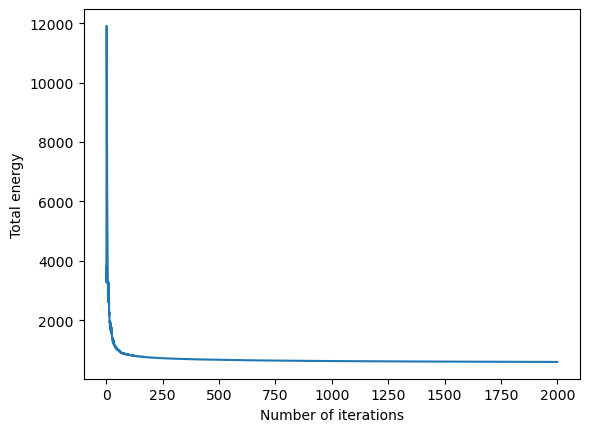

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.10, walk_length=100 completed.
Running simulation with alpha=0.13, walk_length=128


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

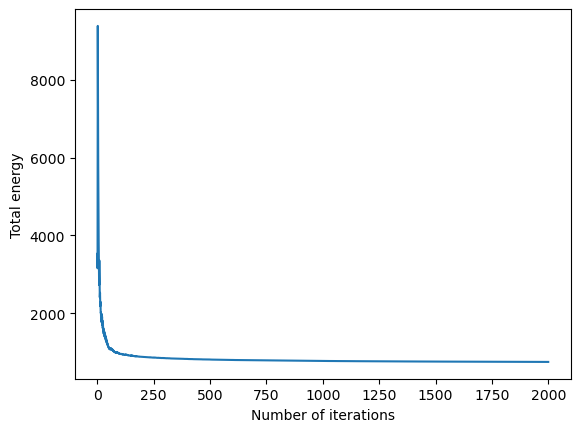

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.13, walk_length=128 completed.
Running simulation with alpha=0.16, walk_length=157


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

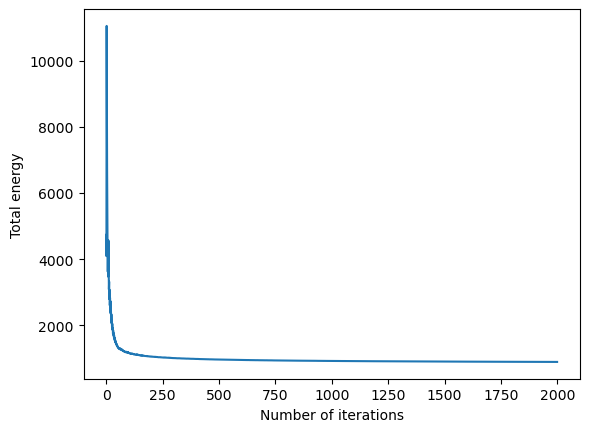

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.16, walk_length=157 completed.
Running simulation with alpha=0.19, walk_length=186


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

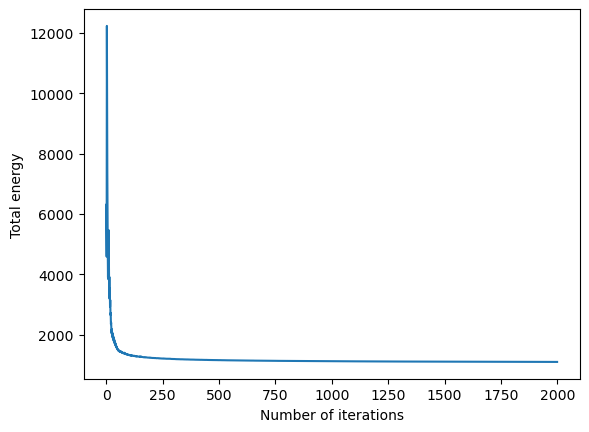

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.19, walk_length=186 completed.
Running simulation with alpha=0.22, walk_length=215


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

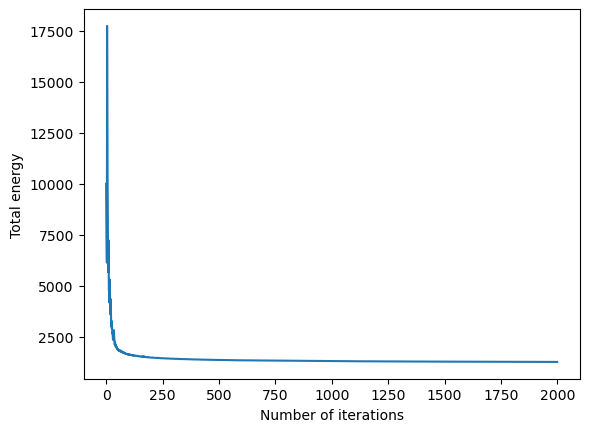

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.22, walk_length=215 completed.
Running simulation with alpha=0.24, walk_length=244


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

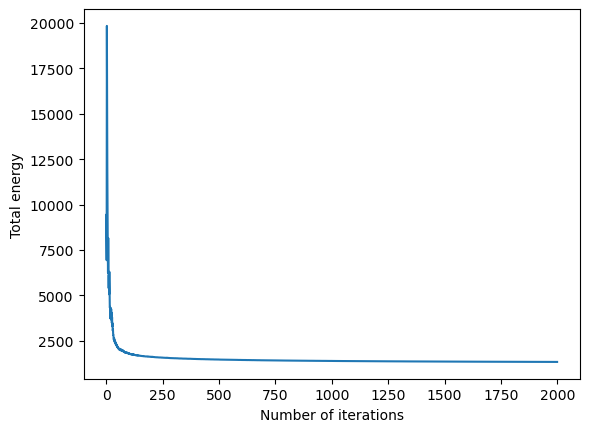

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.24, walk_length=244 completed.
Running simulation with alpha=0.27, walk_length=273


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

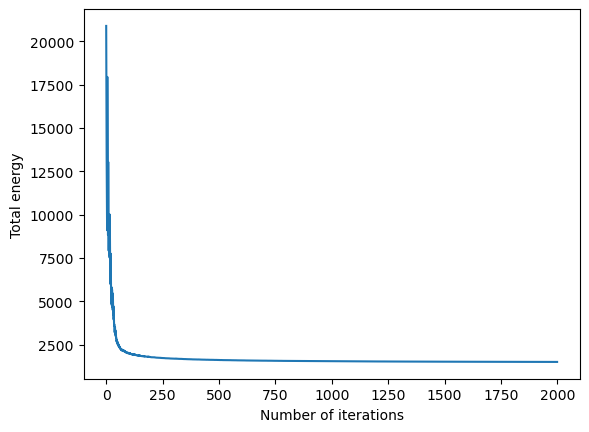

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.27, walk_length=273 completed.
Running simulation with alpha=0.30, walk_length=302


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

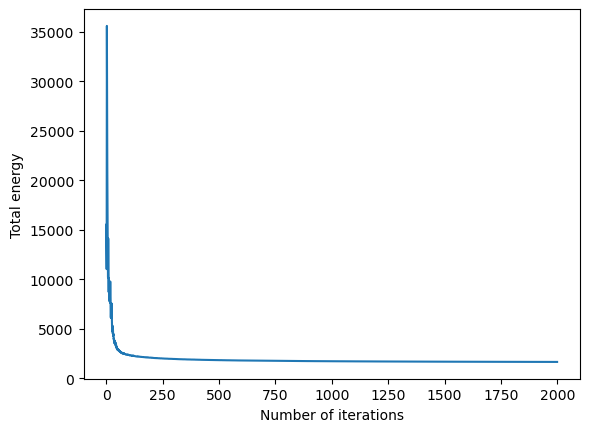

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.30, walk_length=302 completed.
Running simulation with alpha=0.33, walk_length=331


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

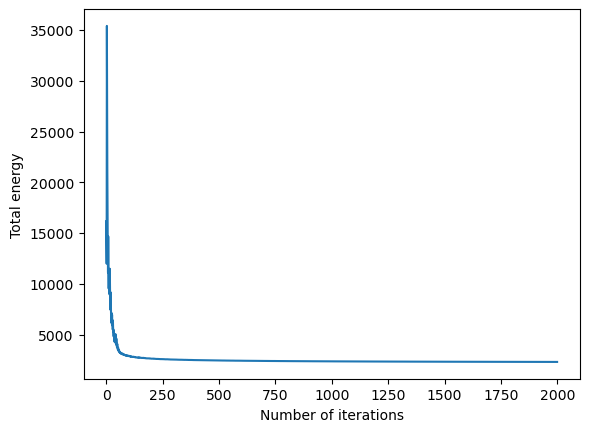

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.33, walk_length=331 completed.
Running simulation with alpha=0.36, walk_length=360


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

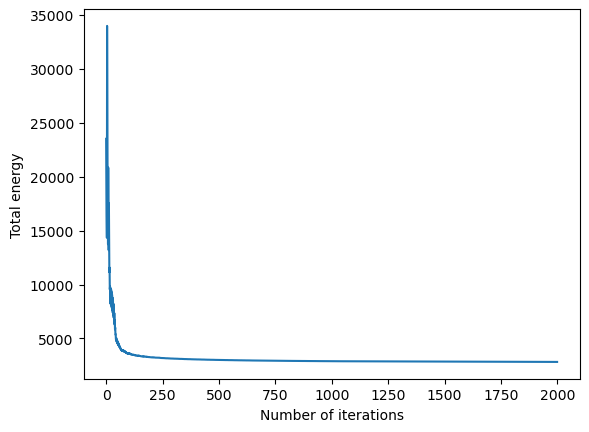

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.36, walk_length=360 completed.
Running simulation with alpha=0.39, walk_length=389


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

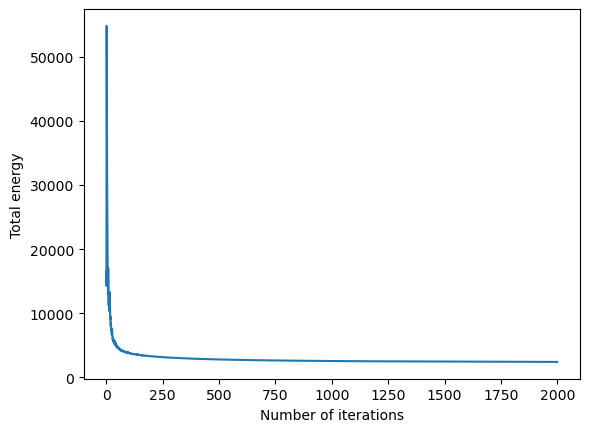

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.39, walk_length=389 completed.
Running simulation with alpha=0.42, walk_length=418


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

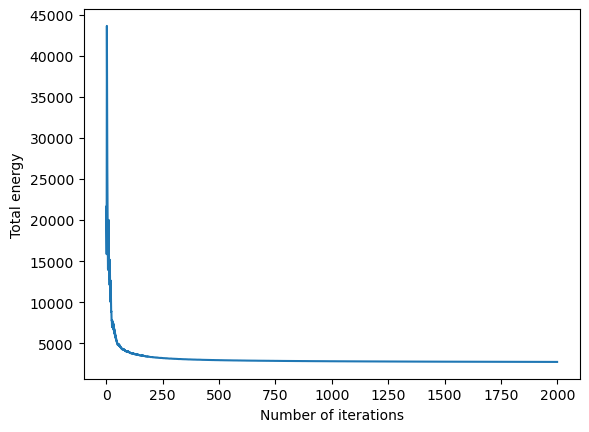

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.42, walk_length=418 completed.
Running simulation with alpha=0.45, walk_length=447


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

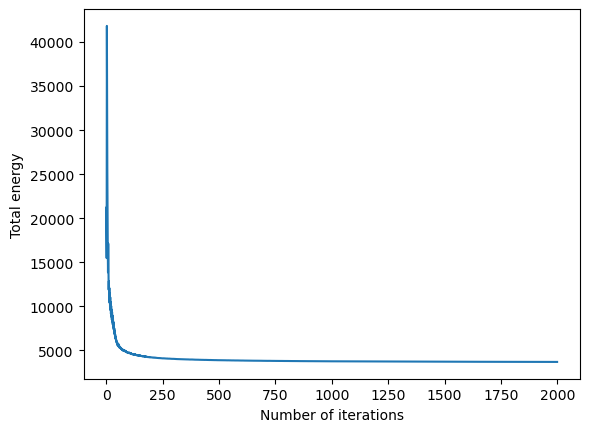

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.45, walk_length=447 completed.
Running simulation with alpha=0.48, walk_length=476


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

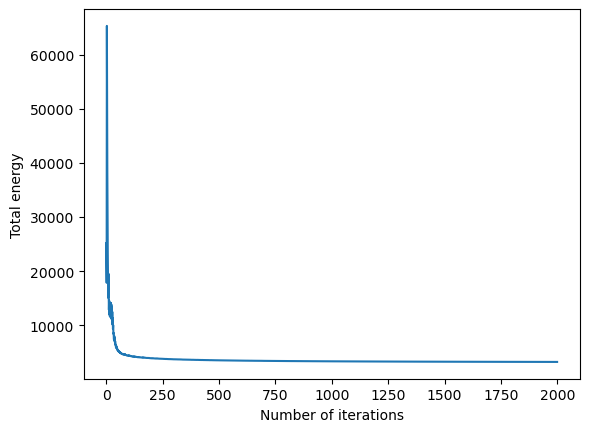

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.48, walk_length=476 completed.
Running simulation with alpha=0.51, walk_length=505


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

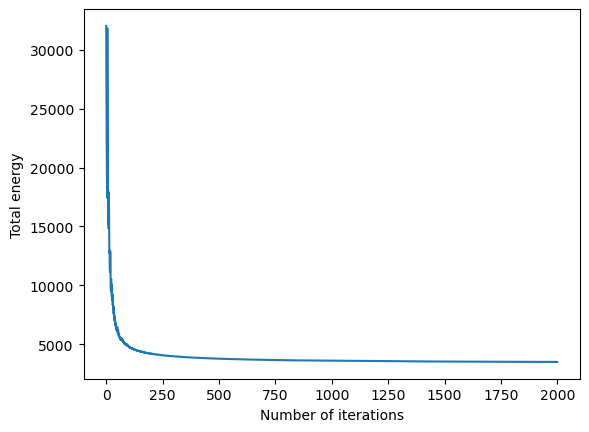

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.51, walk_length=505 completed.
Running simulation with alpha=0.53, walk_length=534


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

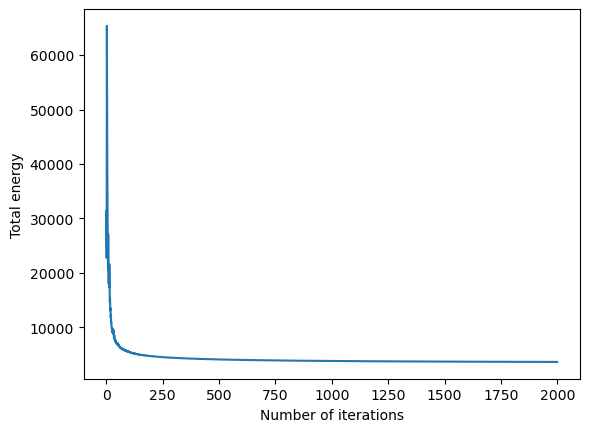

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.53, walk_length=534 completed.
Running simulation with alpha=0.56, walk_length=563


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

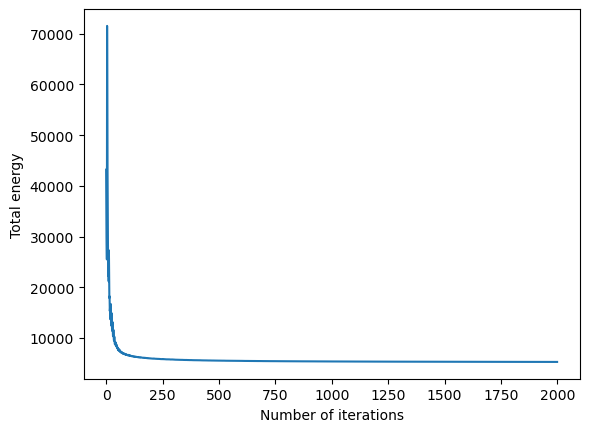

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.56, walk_length=563 completed.
Running simulation with alpha=0.59, walk_length=592


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

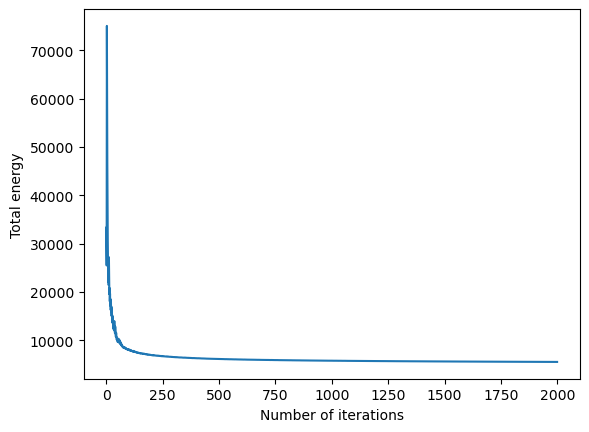

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.59, walk_length=592 completed.
Running simulation with alpha=0.62, walk_length=621


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

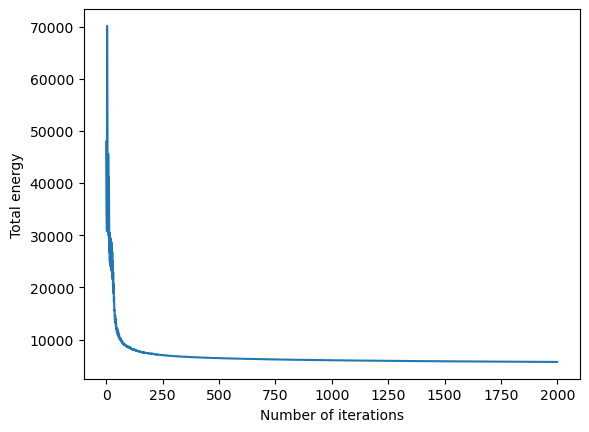

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.62, walk_length=621 completed.
Running simulation with alpha=0.65, walk_length=650


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

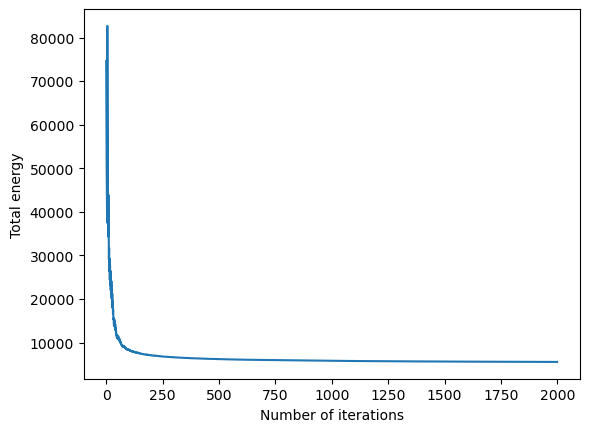

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation with alpha=0.65, walk_length=650 completed.


<Figure size 640x480 with 0 Axes>

In [31]:
# Parameters for coupling
alpha_values = np.linspace(0.1, 0.65, 20)  # Gradually increase alpha from 0.1 to 0.5
walk_length_base = 100                   # Base walk length
walk_length_factor = 1000                   # Factor to scale walk length with alpha

# Loop through increasing severity
for alpha in alpha_values:
    walk_length = int(walk_length_base + walk_length_factor * (alpha - alpha_values[0]))
    print(f"Running simulation with alpha={alpha:.2f}, walk_length={walk_length}")

    # Reset to initial conditions
    spring_constants = np.full(len(edges), k_normal)
    healthy_ids = np.where(spring_constants == k_normal)[0]
    
    # Run random walk for fibrosis initialization
    while len(healthy_ids) / len(edges) > 1 - alpha:
        feasible_ids = np.where((spring_constants == k_normal) & (boundary_edge_ids == 1))[0]
        new_stiff = np.random.choice(feasible_ids)
        spring_constants[new_stiff] = k_fibrosis

        # Do random walk (spread fibrosis)
        for i in range(walk_length):
            nodes = edges[new_stiff]
            connected = np.where(
                (nodes[0] == edges[:, 0]) | (nodes[0] == edges[:, 1]) |
                (nodes[1] == edges[:, 0]) | (nodes[1] == edges[:, 1])
            )
            new_stiff = np.random.choice(connected[0])
            spring_constants[new_stiff] = k_fibrosis

        # Update
        healthy_ids = np.where(spring_constants == k_normal)[0]

    # Pre-convergence step
    points = np.asarray(points, dtype=np.float64)
    edges = np.asarray(edges, dtype=np.int32)
    spring_constants = np.asarray(spring_constants, dtype=np.float64)

    pre_convergence_iterations = 2000
    final_positions, final_edges, final_spring_constants = simulate(
        points, edges, l0, spring_constants, mu, T, tolerance, pre_convergence_iterations, free_nodes
    )

    points = final_positions
    edges = final_edges
    spring_constants = final_spring_constants
    A = spring_constants
    strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
    
    # Save the result
    # filename = os.path.join(
    #     output_folder, f"fibrosis_alpha_{alpha:.2f}_walk_{walk_length}_result.vtk"
    # )

    filename = os.path.join(
        output_folder, f"fibrosis_alpha_{alpha:.2f}.vtk"
    )
    meshio.write(
        filename,
        meshio.Mesh(
            final_positions,
            cells=[("line", final_edges)],
            cell_data={
                "Stiffness": [spring_constants],
                "Strain": [strain],
                "Stress": [stress]
            }
        )
    )
    print(f"Simulation with alpha={alpha:.2f}, walk_length={walk_length} completed.")
